# Load files and libraries

In [1]:
!wget -q https://raw.githubusercontent.com/lcrosvila/SPICE_LIME/main/lime.py
!wget -q https://raw.githubusercontent.com/lcrosvila/SPICE_LIME/main/spice.py
!wget -q https://raw.githubusercontent.com/lcrosvila/SPICE_LIME/main/utils.py

In [2]:
!sudo apt-get install -qq -y timidity libsndfile1

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package freepats.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../freepats_20060219-1_all.deb ...
Unpacking freepats (20060219-1) ...
Selecting previously unselected package libaudio2:amd64.
Preparing to unpack .../libaudio2_1.9.4-6_amd64.deb ...
Unpacking libaudio2:amd64 (1.9.4-6) ...
Selecting previously unselected package timidity.
Preparing to unpack .../timidity_2.13.2-41_amd64.deb ...
Unpacking timidity (2.13.2-41) ...
Selecting previously unselected package t

In [3]:
# All the imports to deal with sound data
!pip -q install pydub numba==0.48 librosa music21 scipy==1.2.0

     |████████████████████████████████| 3.5 MB 37.8 MB/s 
     |████████████████████████████████| 26.6 MB 1.6 MB/s 
     |████████████████████████████████| 20.2 MB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.2.25 requires scipy>=1.2.1, but you have scipy 1.2.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Define the models

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay

import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile

from base64 import b64decode

import statistics
from statistics import mode

import music21
from pydub import AudioSegment

import warnings
warnings.filterwarnings('ignore')

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print("tensorflow: %s" % tf.__version__)
#print("librosa: %s" % librosa.__version__)

tensorflow: 2.7.0


In [6]:
#@title Texto de título predeterminado
from lime import LIME
from spice import SPICE

att = -6 # [0, -6, -12]

if att != 0:
  att_db = 10**(att/20)
else:
  att_db = 0.0

config = {"model_load_path": "https://tfhub.dev/google/spice/2",
          "audio_path": "c-scale.wav",
          "num_segments": 100,
          "num_perturb": 150,
          "kernel_width": 0.25,
          "model_type": "spice",
          "pred_precision": None,
          "attenuation": att_db,
          "num_top_features": 4}

spice = SPICE(config)
spice.get_model()

lime = LIME(config, spice)

In [ ]:
#@title [Run this] Definition of the JS code to record audio straight from the browser

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  try:
    from google.colab import output
  except ImportError:
    print('No possible to import output from google.colab')
    return ''
  else:
    print('Recording')
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    fname = 'recorded_audio.wav'
    print('Saving to', fname)
    b = b64decode(s.split(',')[1])
    with open(fname, 'wb') as f:
      f.write(b)
    return fname

# Input the audio

In [13]:
#@title Select how to input your audio  { run: "auto" }
INPUT_SOURCE = 'https://docs.google.com/uc?export=download&id=1-XYjeDOUoyLy-oyiPWgLMFbhxamrbGmP' #@param ["https://docs.google.com/uc?export=download&id=1-XYjeDOUoyLy-oyiPWgLMFbhxamrbGmP", "RECORD", "UPLOAD", "./drive/My Drive/YOUR_MUSIC_FILE.wav"] {allow-input: true}

print('You selected', INPUT_SOURCE)

if INPUT_SOURCE == 'RECORD':
  uploaded_file_name = record(5)
elif INPUT_SOURCE == 'UPLOAD':
  try:
    from google.colab import files
  except ImportError:
    print("ImportError: files from google.colab seems to not be available")
  else:
    uploaded = files.upload()
    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    uploaded_file_name = next(iter(uploaded))
    print('Uploaded file: ' + uploaded_file_name)
elif INPUT_SOURCE.startswith('./drive/'):
  try:
    from google.colab import drive
  except ImportError:
    print("ImportError: files from google.colab seems to not be available")
  else:
    drive.mount('/content/drive')
    # don't forget to change the name of the file you
    # will you here!
    gdrive_audio_file = 'YOUR_MUSIC_FILE.wav'
    uploaded_file_name = INPUT_SOURCE
elif INPUT_SOURCE.startswith('http'):
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-XYjeDOUoyLy-oyiPWgLMFbhxamrbGmP' -O original.wav
  uploaded_file_name = 'original.wav'
else:
  print('Unrecognized input format!')
  print('Please select "RECORD", "UPLOAD", or specify a file hosted on Google Drive or a file from the web to download file to download')

You selected https://docs.google.com/uc?export=download&id=1-XYjeDOUoyLy-oyiPWgLMFbhxamrbGmP
--2021-12-01 07:52:27--  https://docs.google.com/uc?export=download&id=1-XYjeDOUoyLy-oyiPWgLMFbhxamrbGmP
Resolving docs.google.com (docs.google.com)... 142.250.188.206, 2607:f8b0:4004:836::200e
Connecting to docs.google.com (docs.google.com)|142.250.188.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/83kp2enn5ue9o378eoi5pfkm3d3kij81/1638345075000/15231227763936357553/*/1-XYjeDOUoyLy-oyiPWgLMFbhxamrbGmP?e=download [following]
--2021-12-01 07:52:27--  https://doc-08-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/83kp2enn5ue9o378eoi5pfkm3d3kij81/1638345075000/15231227763936357553/*/1-XYjeDOUoyLy-oyiPWgLMFbhxamrbGmP?e=download
Resolving doc-08-a0-docs.googleusercontent.com (doc-08-a0-docs.googleusercontent.com)... 142.251.45.97, 260

# Show results

Predicted notes:  ['C#3', 'A3', 'A#3', 'A#3', 'C3', 'F#3']
Used NOTE is:  A#3
ORIGINAL AUDIO


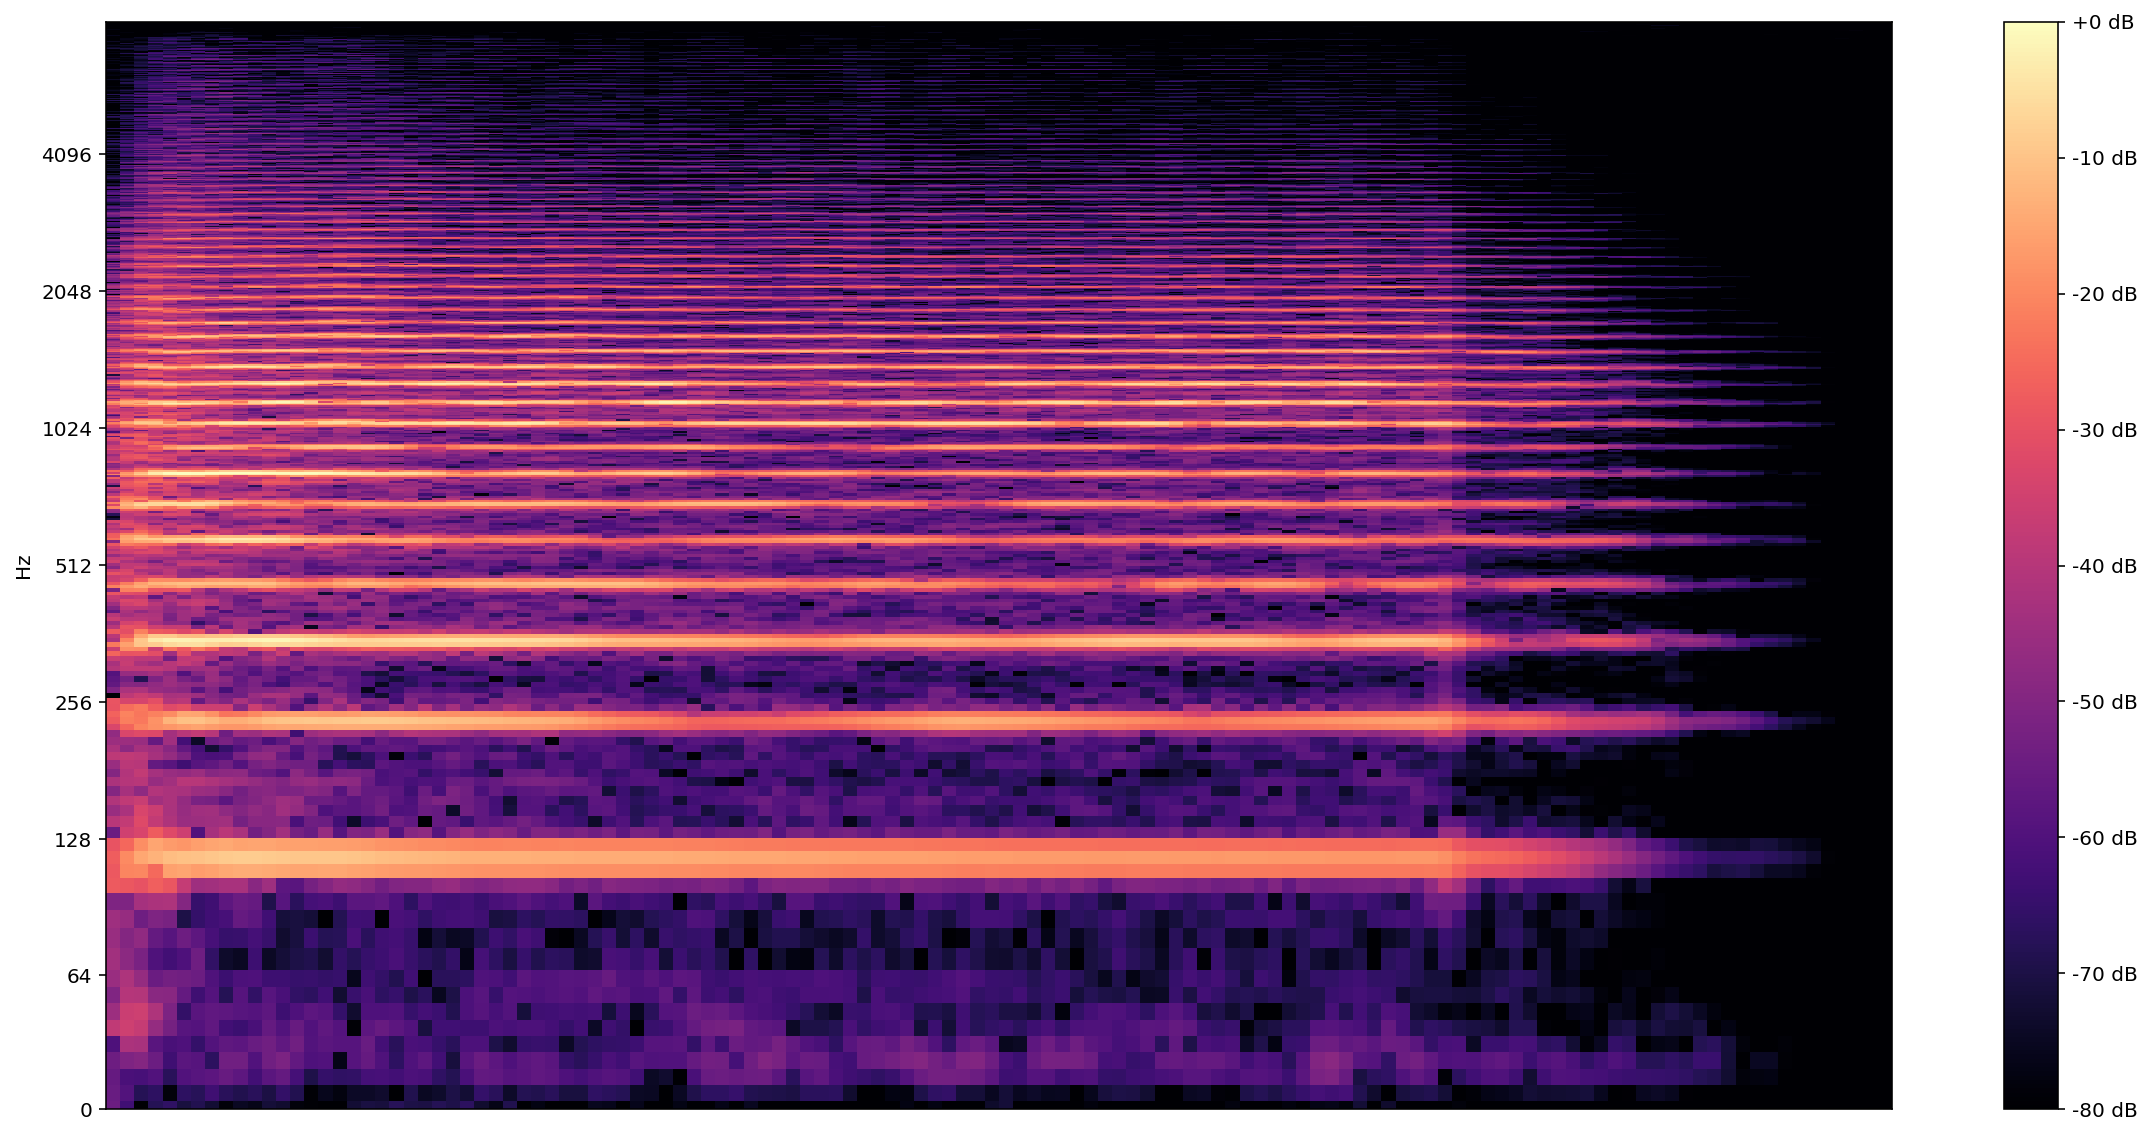

XTOP


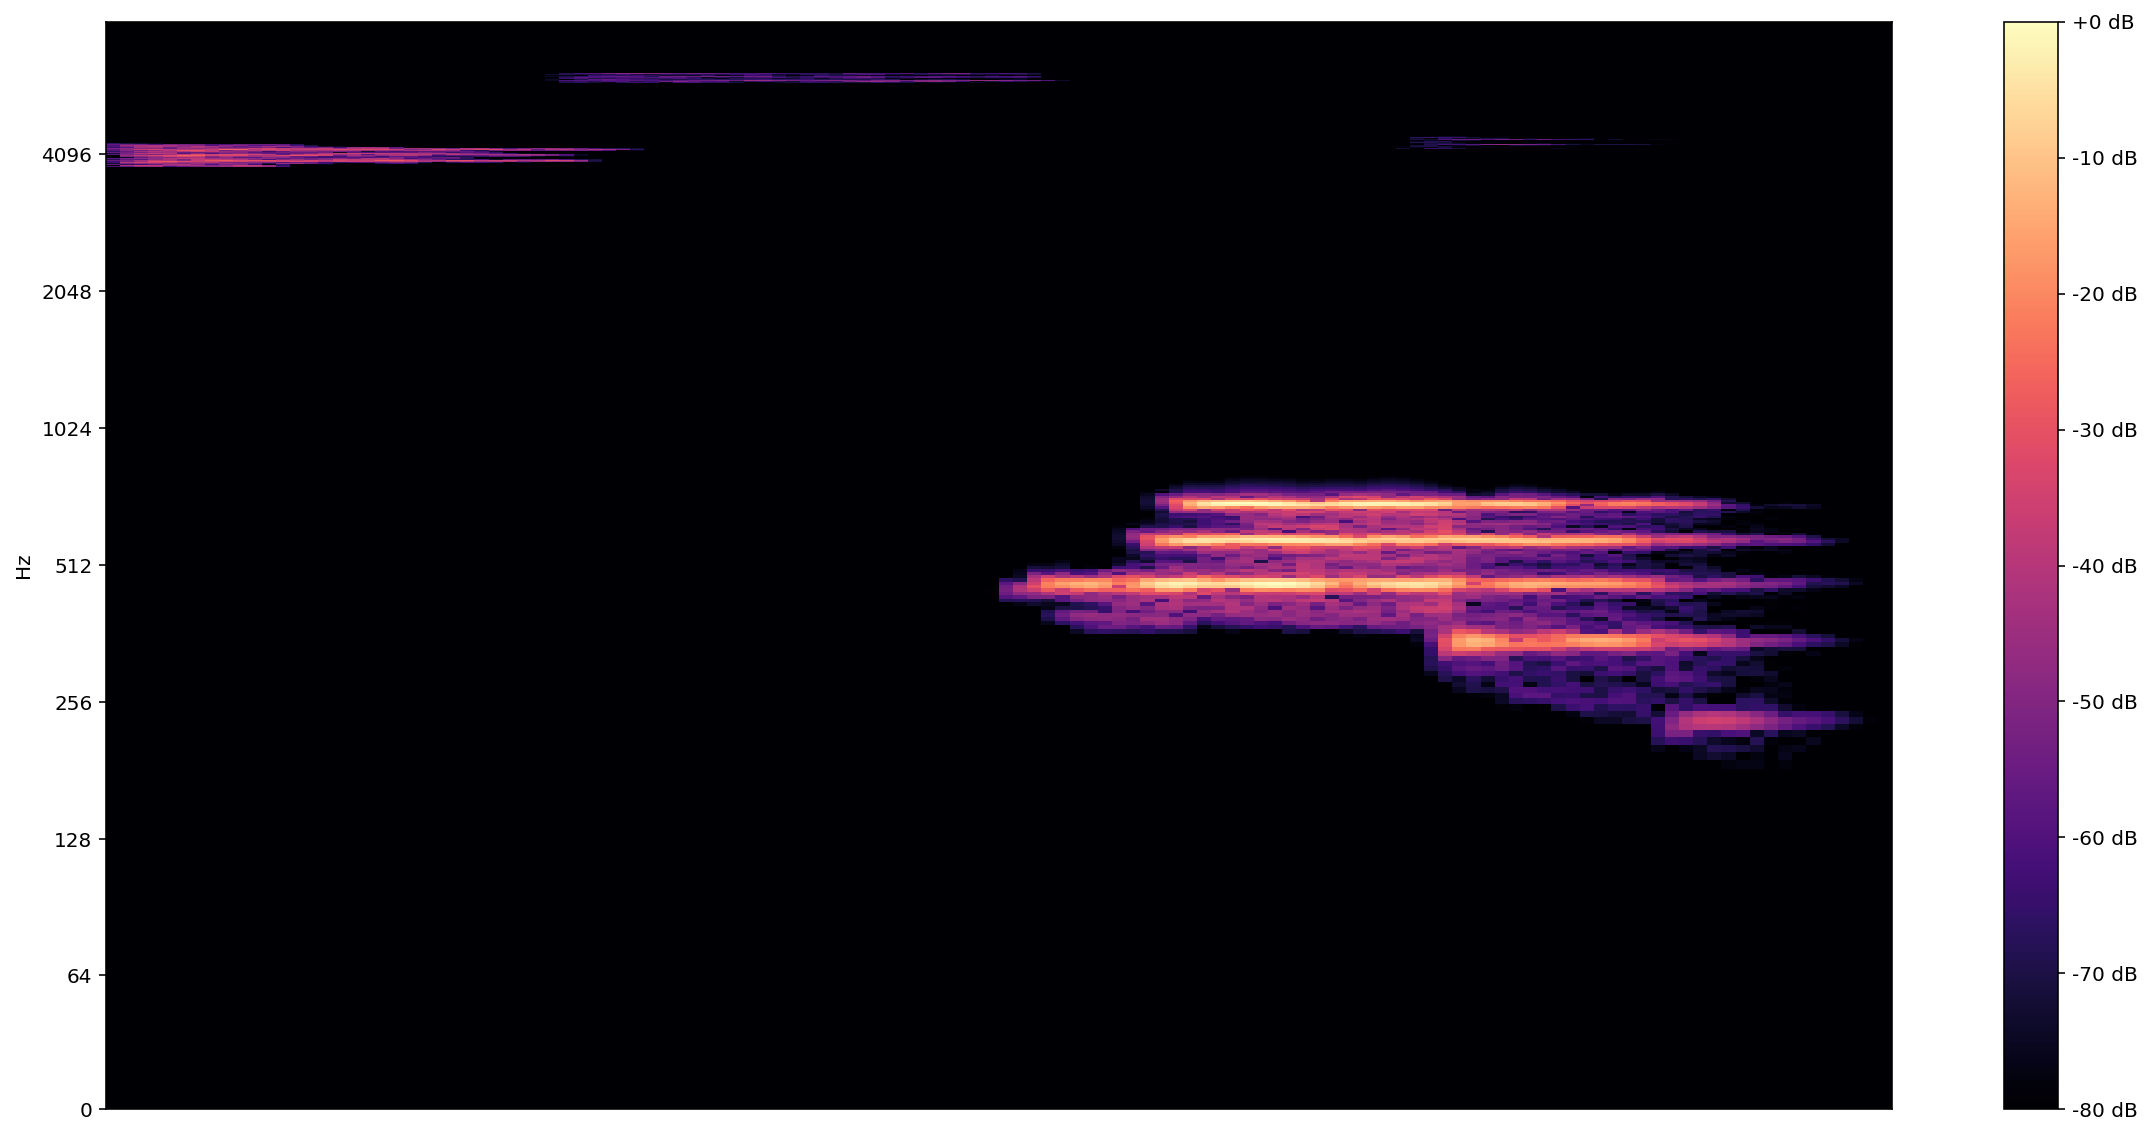

XBOTTOM


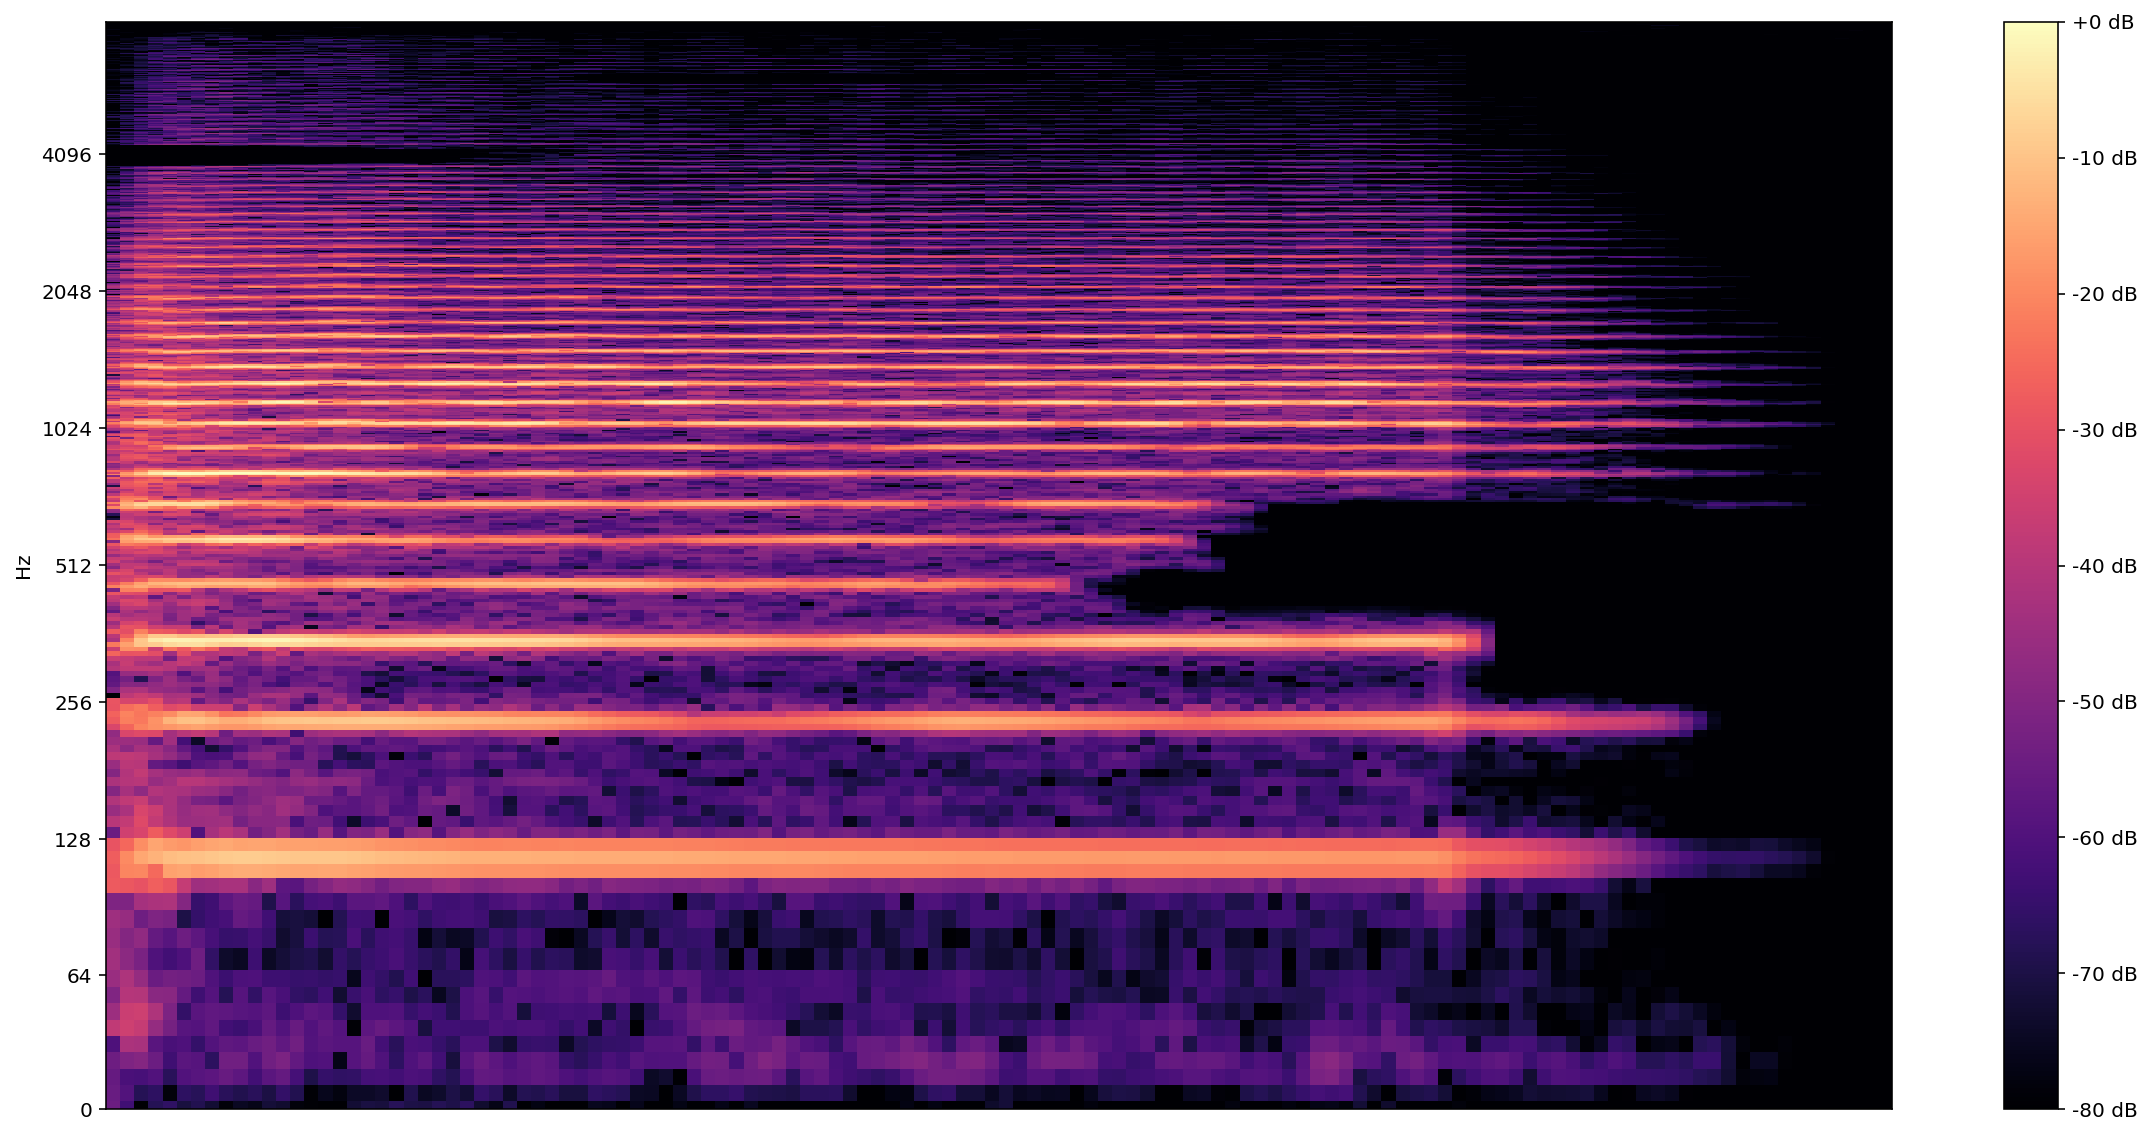

In [16]:
#@title LIME explanation of SPICE Pitch Detection { run: "auto" }
from utils import plot_stft, play_audio

config["audio_path"] = uploaded_file_name
audio_samples, sample_rate = spice.load_audio(config["audio_path"])

pitch_outputs, confidence_outputs, mean_outputs = spice.get_predictions(audio_samples)
predicted_notes = spice.get_notes(pitch_outputs, confidence_outputs)

print("Predicted notes: ", predicted_notes)

NOTE = "use predicted one" #@param ["use most predicted one", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"] {allow-input: true}
OCTAVE = "use predicted one" #@param ["use most predicted one", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"] {allow-input: true}

if NOTE == "use predicted one":
   NOTE = mode([a for a in predicted_notes])
   if OCTAVE != "use predicted one":
      NOTE[-1] = OCTAVE
   
else:
   if OCTAVE != "use predicted one":
      NOTE[-1] = OCTAVE
   else:
      NOTE[-1] = mode([a for a in predicted_notes])[-1]

print("Used NOTE is: ", NOTE)

X_top, X_bottom = lime.get_top_bottom(audio_samples, NOTE)

X_top_orig, X_bottom_orig = X_top.copy(), X_bottom.copy()

print("ORIGINAL AUDIO")
# Original audio
plot_stft(audio_samples, sample_rate)
play_audio(audio_samples, sample_rate)

print("XTOP")
# Xtop
plot_stft(X_top["audio"], sample_rate)
play_audio(X_top["audio"], sample_rate)

print("XBOTTOM")
#Xbottom
plot_stft(X_bottom["audio"], sample_rate)
play_audio(X_bottom["audio"], sample_rate)

Predicted notes:  ['C#3', 'A3', 'A#3', 'A#3', 'C#3', 'G3']
Used NOTE is:  A#3
ORIGINAL AUDIO


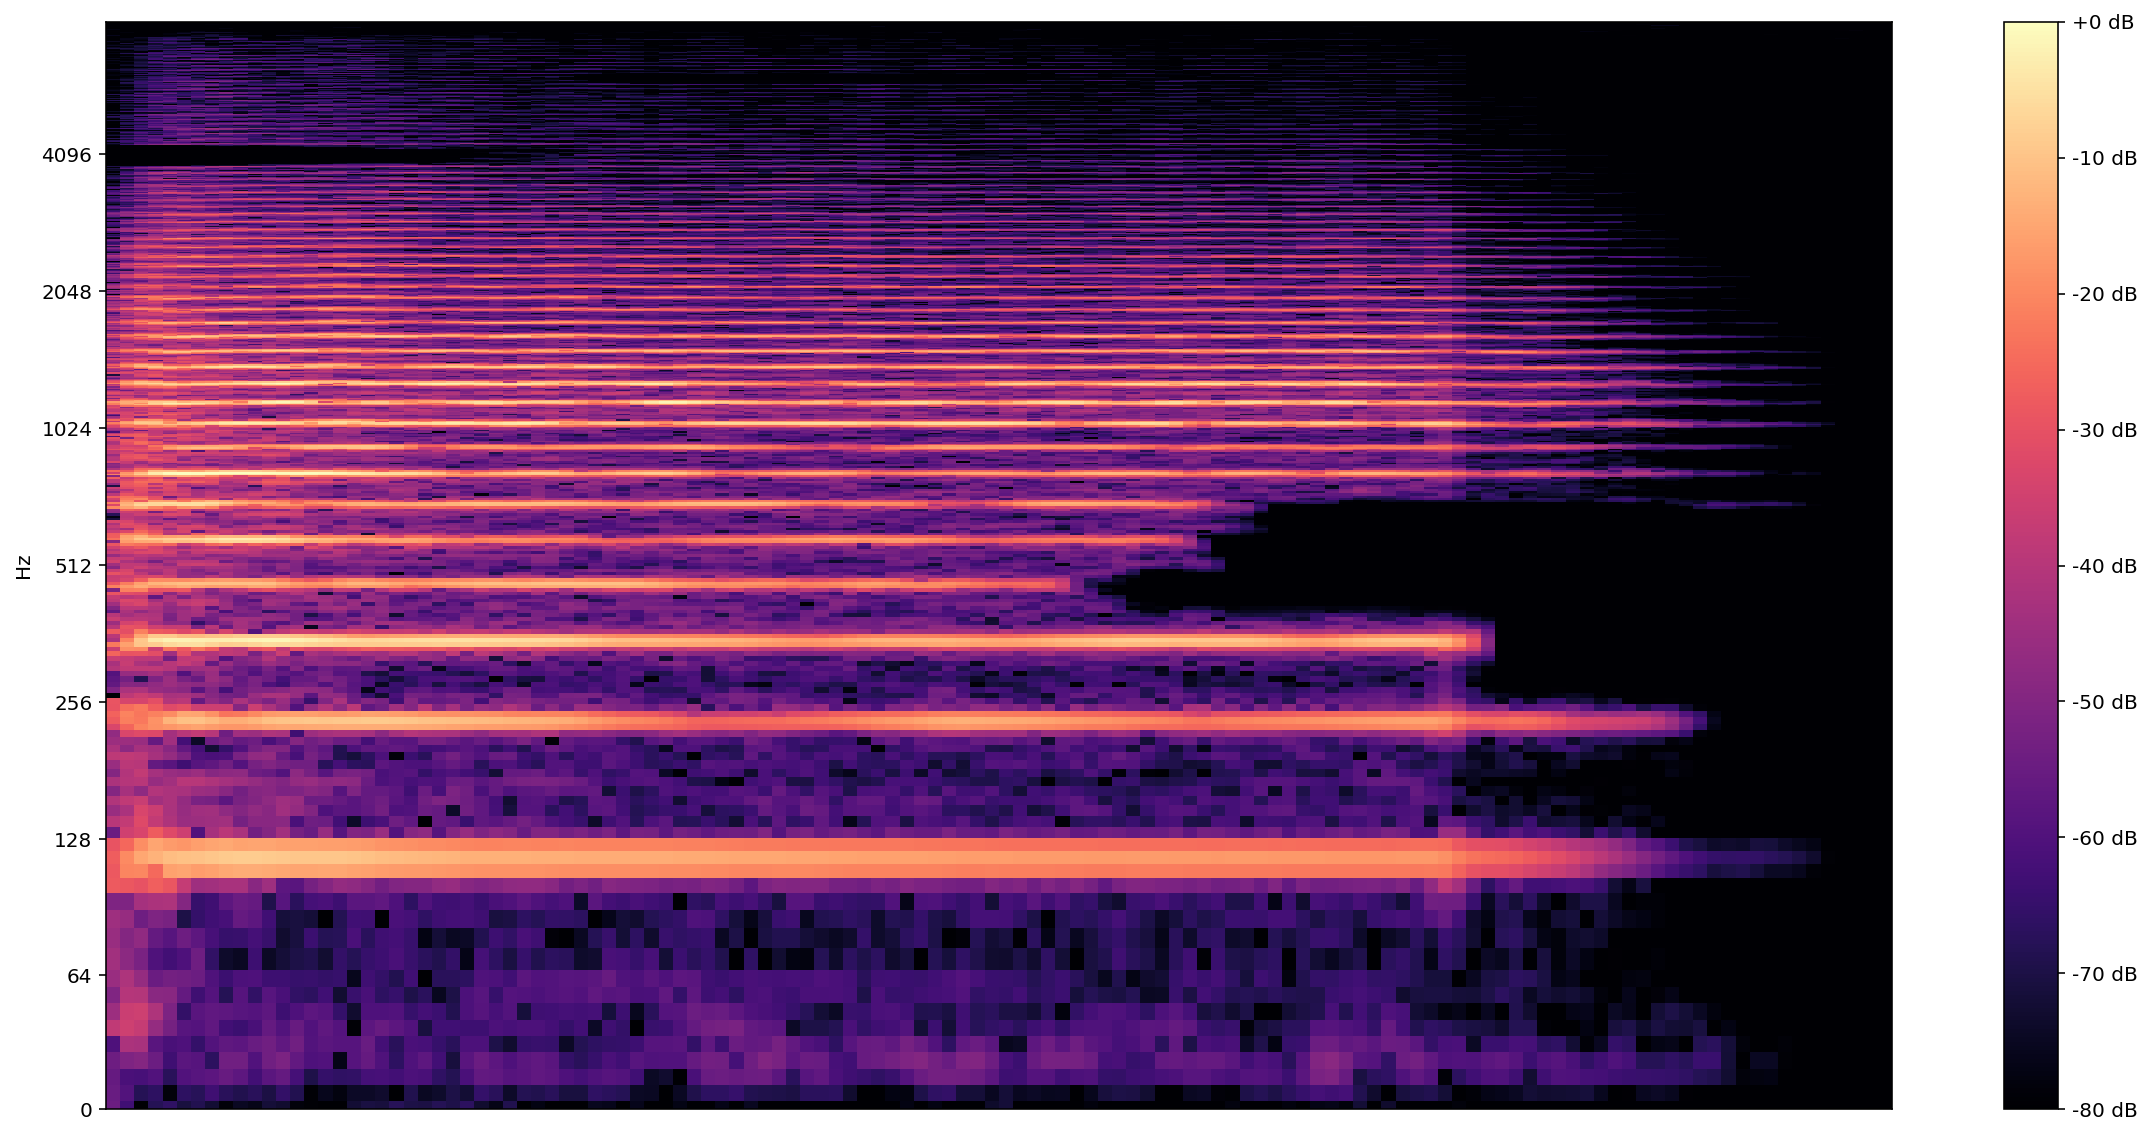

XTOP


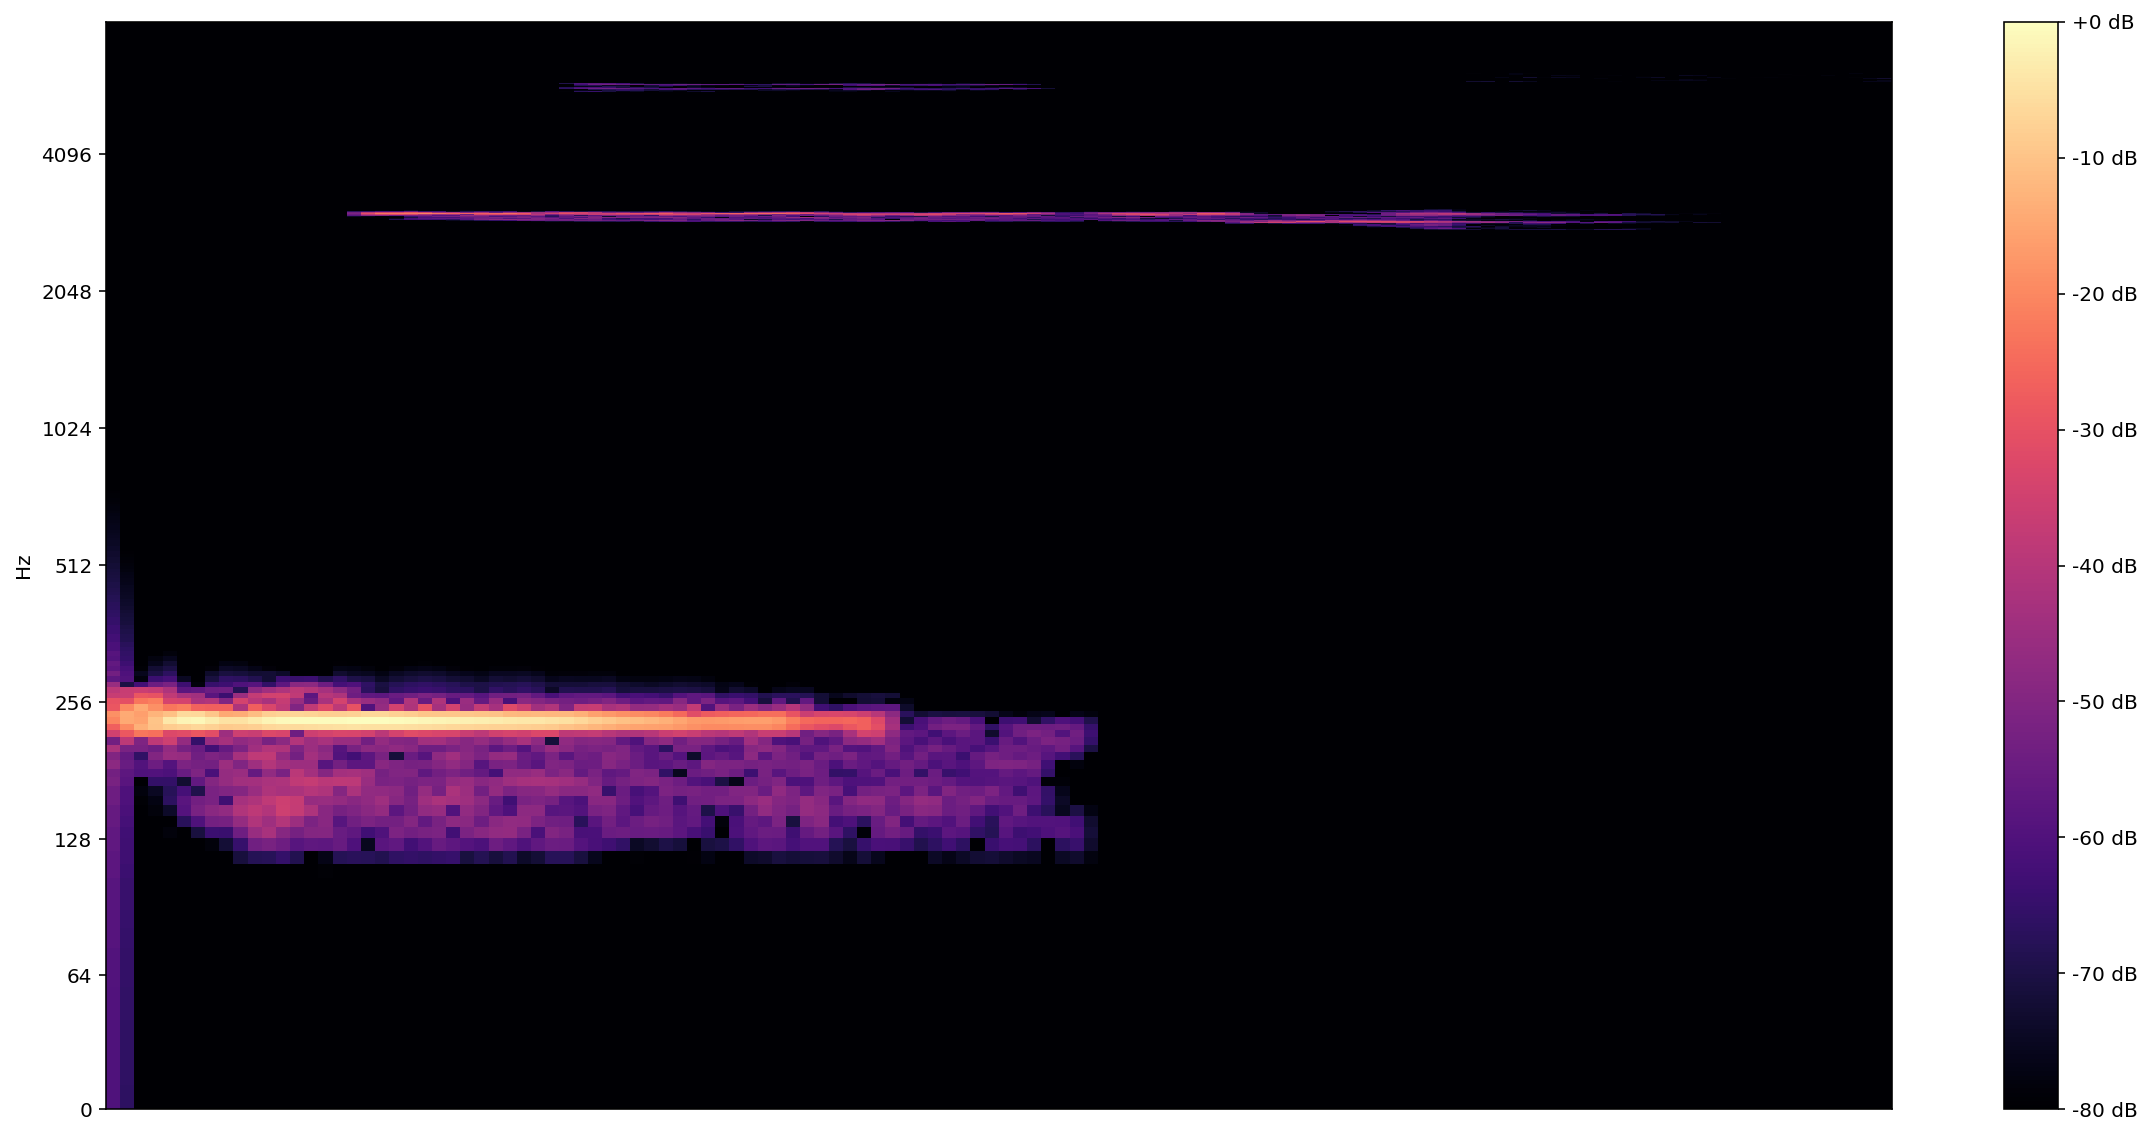

XBOTTOM


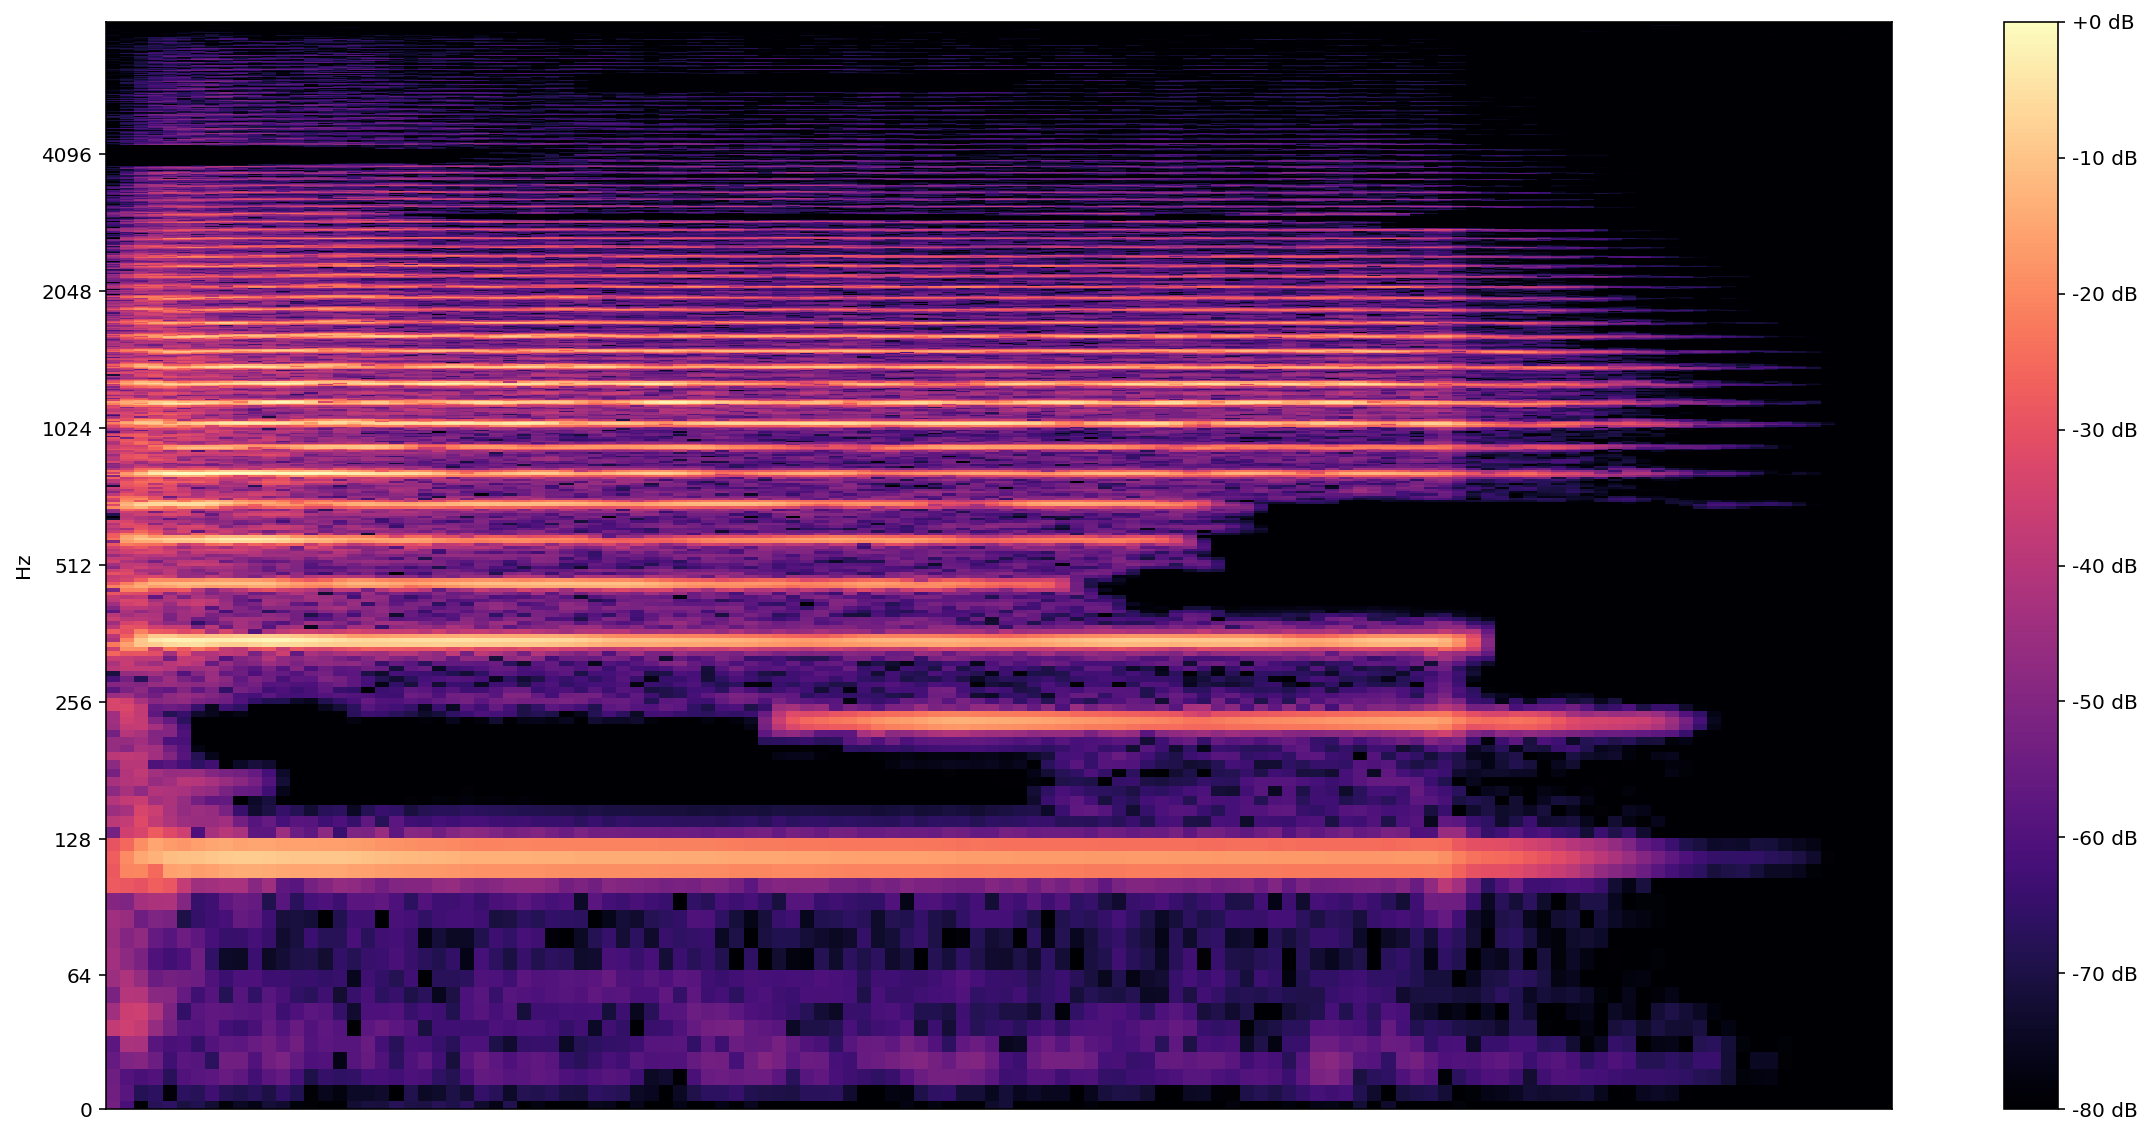

In [17]:
#@title Do it again!

from_what = "Xbottom" #@param ["Xtop", "Xbottom"] {allow-input: true}
allow_recursion = "No" #@param ["Yes", "No"] {allow-input: true}

if allow_recursion == "No": 
  if from_what == "Xtop":
    audio_samples = X_top_orig["audio"]
  elif from_what == "Xbottom":
    audio_samples = X_bottom_orig["audio"]

elif allow_recursion == "Yes":
  if from_what == "Xtop":
    audio_samples = X_top["audio"]
  elif from_what == "Xbottom":
    audio_samples = X_bottom["audio"]

pitch_outputs, confidence_outputs, mean_outputs = spice.get_predictions(audio_samples)
predicted_notes = spice.get_notes(pitch_outputs, confidence_outputs)

print("Predicted notes: ", predicted_notes)

new_NOTE = "use same as before" #@param ["use same as before", "use most predicted one", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"] {allow-input: true}
new_OCTAVE = "use same as before" #@param ["use same as before", "use most predicted one", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"] {allow-input: true}

if new_NOTE == "use same as before":
   new_NOTE = NOTE
   if new_OCTAVE == "use most predicted one":
      new_NOTE[-1] = mode([a for a in predicted_notes])[-1]
   elif new_OCTAVE != "use same as before":
      new_NOTE[-1] = new_OCTAVE

if new_NOTE == "use most predicted one":
   new_NOTE = mode([a for a in predicted_notes])
   if new_OCTAVE == "use most predicted one":
      new_NOTE[-1] = mode([a for a in predicted_notes])[-1]
   elif new_OCTAVE != "use same as before":
      new_NOTE[-1] = new_OCTAVE

print("Used NOTE is: ", new_NOTE)

X_top, X_bottom = lime.get_top_bottom(audio_samples, NOTE)

print("ORIGINAL AUDIO")
# Original audio
plot_stft(audio_samples, sample_rate)
play_audio(audio_samples, sample_rate)

print("XTOP")
# Xtop
plot_stft(X_top["audio"], sample_rate)
play_audio(X_top["audio"], sample_rate)

print("XBOTTOM")
#Xbottom
plot_stft(X_bottom["audio"], sample_rate)
play_audio(X_bottom["audio"], sample_rate)